In [1]:
import sys

# Check if running on Google Colab
# If so, mount Google Drive and download CIFAR-10 dataset
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # assignment folder, e.g. 'cs231n/assignments/assignment1/'
    FOLDERNAME = None
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    # This downloads the CIFAR-10 dataset to your Drive
    # if it doesn't already exist.
    %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
    !bash get_datasets.sh
    %cd /content/drive/My\ Drive/$FOLDERNAME
# END OF COLAB SETUP

# If not running on Google Colab, download CIFAR-10 dataset locally
else:
    print("Not running on Google Colab")
    %cd ./cs231n/datasets/
    !bash get_datasets.sh
    %cd ../..

Not running on Google Colab
/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/Entregables/assignment1/cs231n/datasets
/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/Entregables/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://eva.fing.edu.uy/mod/assign/view.php?id=194303) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax on features
Using the multiclass Softmax code developed earlier in the assignment, train Softmax on top of the features extracted above; this should achieve better results than training Softmax directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-3, 5e-3, 1e-5, 5e-5, 1e-7, 5e-7, 1e-9, 5e-9, 1e-10, 5e-10, 1e-12, 5e-12]
regularization_strengths = [10, 50, 1e2, 2e2, 1e3, 5e3, 2.5e4, 5e4, 1e6, 2e6]

results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax;     #
# save the best trained classifer in best_softmax. You might also want to play #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.42 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# All-for-all GridSearch
for lr in learning_rates:
    for rs in regularization_strengths:

        # Initialize classifier
        softmax = Softmax()
        # Train
        loss_hist = softmax.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=False)
        # Evaluate on train
        y_train_pred = softmax.predict(X_train_feats)
        # Evaluate on validation
        y_val_pred = softmax.predict(X_val_feats)
        
        # Accuracies
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)

        # Update dictionary (train, val)
        results[(lr,rs)] = (train_acc, val_acc)

        # Compare with previous parameters
        if val_acc > best_val:
            # If accuracy increases, update the best result and the classifier
            best_val = val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/Entregables/assignment1/cs231n/classifiers/softmax.py:94: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(np.log(np.e**s_y / np.sum(np.e**s))) + reg * np.sum(W**2)
/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/Entregables/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: invalid value encountered in divide
  P = np.e ** s / np.sum(np.e ** s, axis = 1, keepdims=True)


lr 1.000000e-12 reg 1.000000e+01 train accuracy: 0.093143 val accuracy: 0.091000
lr 1.000000e-12 reg 5.000000e+01 train accuracy: 0.085694 val accuracy: 0.088000
lr 1.000000e-12 reg 1.000000e+02 train accuracy: 0.098327 val accuracy: 0.089000
lr 1.000000e-12 reg 2.000000e+02 train accuracy: 0.089224 val accuracy: 0.091000
lr 1.000000e-12 reg 1.000000e+03 train accuracy: 0.099633 val accuracy: 0.110000
lr 1.000000e-12 reg 5.000000e+03 train accuracy: 0.093510 val accuracy: 0.091000
lr 1.000000e-12 reg 2.500000e+04 train accuracy: 0.098286 val accuracy: 0.085000
lr 1.000000e-12 reg 5.000000e+04 train accuracy: 0.113469 val accuracy: 0.109000
lr 1.000000e-12 reg 1.000000e+06 train accuracy: 0.092918 val accuracy: 0.101000
lr 1.000000e-12 reg 2.000000e+06 train accuracy: 0.100429 val accuracy: 0.105000
lr 5.000000e-12 reg 1.000000e+01 train accuracy: 0.113490 val accuracy: 0.107000
lr 5.000000e-12 reg 5.000000e+01 train accuracy: 0.117714 val accuracy: 0.140000
lr 5.000000e-12 reg 1.000000

In [6]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.40
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


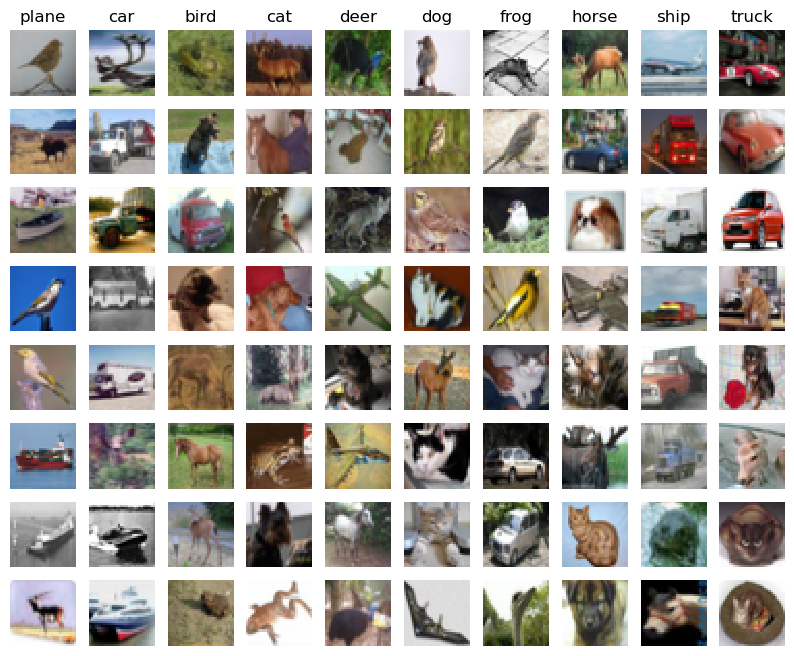

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

Errors make a lot of sense!

The model pays special attention to pixel values and images showing a vast majority of pixel values that match, will be classified as belonging to the same class.

For instance, fifth image on the ship column (starting from 0), displays a plane surrounding by blue... Blue is the color of the sea, which makes this image to be classified as a ship given its blue background.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [13]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver
import itertools

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#################################################################################
### FUNCTION THAT PERFORMS THE TRAINING BASED ON PARAMETERS

def train_ann(data, hidden_size, learning_rate, num_epochs, reg, batch_size):

    input_size = data['X_train'].shape[1]
    num_classes = 10
    
    model = TwoLayerNet(input_size, hidden_size, num_classes)
    model.reg = reg

    solver = Solver(model, 
                    data,
                    update_rule='sgd',
                    optim_config={
                        'learning_rate': learning_rate,
                    },
                    lr_decay=0.9,
                    num_epochs=num_epochs, 
                    batch_size=batch_size,
                    print_every=100)

    solver.train()   

    return solver, model

#################################################################################

#################################################################################

best_val_accuracy = -1
results = {}

param_grid = {
    'hidden_size': [ 400, 700, 800], 
    'learning_rate': [1e-3, 1e-2],  
    'num_epochs': [20, 30, 40],  
    'reg': [0.1, 0.01],  
    #'lr_decay': [0.9, 0.95],  
    'batch_size': [64, 32]  
}

# Grid search with itertools.product
keys, values = zip(*param_grid.items())

for v in itertools.product(*values):
    params = dict(zip(keys, v))

    print(f"Training with parameters: {params}")

    solver, model = train_ann(data, **params)

    # Update dictionary (train, val)
    results[tuple(params.items())] = (np.mean(solver.train_acc_history), np.mean(solver.val_acc_history))

    # Track the best model
    if np.mean(solver.val_acc_history) > best_val_accuracy:
        best_val_accuracy = np.mean(solver.val_acc_history)
        best_model = model
        best_solver = solver
        best_params = params  # Save the best hyperparameters
        print(f"New best model found with validation accuracy: {best_val_accuracy:.4f}")

# Summary of best results
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Best hyperparameters: {best_params}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Training with parameters: {'hidden_size': 400, 'learning_rate': 0.001, 'num_epochs': 20, 'reg': 0.1, 'batch_size': 64}
(Iteration 1 / 15300) loss: 2.305829
(Epoch 0 / 20) train acc: 0.081000; val_acc: 0.111000
(Iteration 101 / 15300) loss: 2.305859
(Iteration 201 / 15300) loss: 2.305734
(Iteration 301 / 15300) loss: 2.305643
(Iteration 401 / 15300) loss: 2.305559
(Iteration 501 / 15300) loss: 2.305439
(Iteration 601 / 15300) loss: 2.305449
(Iteration 701 / 15300) loss: 2.305137
(Epoch 1 / 20) train acc: 0.202000; val_acc: 0.168000
(Iteration 801 / 15300) loss: 2.305342
(Iteration 901 / 15300) loss: 2.305419
(Iteration 1001 / 15300) loss: 2.305173
(Iteration 1101 / 15300) loss: 2.304792
(Iteration 1201 / 15300) loss: 2.304856
(Iteration 1301 / 15300) loss: 2.305256
(Iteration 1401 / 15300) loss: 2.304795
(Iteration 1501 / 15300) loss: 2.304830
(Epoch 2 / 20) train acc: 0.096000; val_acc: 0.079000
(Iteration 1601 / 15300) loss: 2.304808
(Iteration 1701 / 15300) loss: 2.304780
(Iteration 

In [14]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.521
